In [1]:
import numpy as np
import moviepy.editor as mp
from moviepy.editor import VideoFileClip
from moviepy.editor import AudioFileClip

import matplotlib.pyplot as plt

In [54]:
DELTA = 0.01  # length of subclips to sample over

def get_clip_sample(clip, time_idx):
    '''
    This method takes the original clip, 
    grabs the subclip of length DELTA (in seconds) starting at time `time_idx` (seconds from start), 
    and returns an array representing the loudness of that subclip.
    
    The array can be 2D if the audio is stereo (vs mono). 
    The length of the array is determined by DELTA and the FPS rate of to_soundarray()
    '''
    return clip.audio.subclip(time_idx, time_idx+DELTA).to_soundarray(fps=44100)

def get_average_volume(sound_arr):
    '''
    Returns the average volume of the audio clip given by the loudness array
    
    The array can be 1D or 2D without issue
    '''
    return np.sqrt(((1.0*sound_arr)**2).mean())

def get_sample_volume(clip, time_idx):
    '''
    Grabs the average volume of the subclip of length DELTA starting at time `time_idx`
    '''
    sample = get_clip_sample(clip, time_idx)
    return get_average_volume(sample)

def get_volume_array(clip):
    '''
    Takes as many samples of length DELTA across the duration of the clip
    and returns an array of those samples' average volumes
    '''
    return [get_sample_volume(clip, idx) for idx in np.arange(0, clip.audio.duration, DELTA)]

def get_clipped_video(video, t_start, t_end):
    '''
    Takes start and end times (in seconds) for video and returns clipped
    video and saves it locally
    Times can be expressed in seconds (15.35), in (min, sec), in (hour, min, sec), or as a string: ‘01:03:05.35’
    '''
    clip = video.subclip(t_start, t_end)
    if clip.rotation == 90:
        clip = clip.resize(clip.size[::-1])
        clip.rotation = 0
    clip.write_videofile("clipped-{}-{}.MOV".format(t_start, t_end),
                              temp_audiofile='temp-audio.m4a', remove_temp=True, codec="libx264", audio_codec="aac")


                                                                                
t:   3%|▋                          | 234/8592 [29:59<15:12,  9.16it/s, now=None]
                                                                                
t:   1%|▎                         | 2/150 [16:19<20:08:07, 489.78s/it, now=None]

Moviepy - Building video clipped-30-35.MOV.
MoviePy - Writing audio in temp-audio.m4a




chunk:   0%|                                  | 0/111 [00:00<?, ?it/s, now=None]

chunk:   2%|▍                         | 2/111 [00:00<00:05, 19.80it/s, now=None]

chunk:  97%|██████████████████████▍| 108/111 [00:00<00:00, 628.39it/s, now=None]

                                                                                
t:   3%|▋                          | 234/8592 [29:59<15:12,  9.16it/s, now=None]
                                                                                
t:   1%|▎                         | 2/150 [16:19<20:08:29, 489.93s/it, now=None]

MoviePy - Done.
Moviepy - Writing video clipped-30-35.MOV





t:   0%|                                      | 0/150 [00:00<?, ?it/s, now=None]

t:   1%|▍                             | 2/150 [00:00<00:11, 13.08it/s, now=None]

t:   3%|▊                             | 4/150 [00:00<00:19,  7.67it/s, now=None]

t:   3%|█                             | 5/150 [00:00<00:20,  6.97it/s, now=None]

t:   4%|█▏                            | 6/150 [00:00<00:21,  6.57it/s, now=None]

t:   5%|█▍                            | 7/150 [00:01<00:23,  6.19it/s, now=None]

t:   5%|█▌                            | 8/150 [00:01<00:22,  6.21it/s, now=None]

t:   6%|█▊                            | 9/150 [00:01<00:23,  5.98it/s, now=None]

t:   7%|█▉                           | 10/150 [00:01<00:22,  6.15it/s, now=None]

t:   7%|██▏                          | 11/150 [00:01<00:21,  6.54it/s, now=None]

t:   8%|██▎                          | 12/150 [00:01<00:20,  6.67it/s, now=None]

t:   9%|██▌                          | 13/150 [00:01<00:19,  7.08it/s, now=None]

t:   9%|██▋   

t:  63%|██████████████████▎          | 95/150 [00:14<00:08,  6.68it/s, now=None]

t:  64%|██████████████████▌          | 96/150 [00:14<00:09,  5.67it/s, now=None]

t:  65%|██████████████████▊          | 97/150 [00:14<00:09,  5.71it/s, now=None]

t:  65%|██████████████████▉          | 98/150 [00:14<00:08,  6.23it/s, now=None]

t:  66%|███████████████████▏         | 99/150 [00:14<00:07,  6.64it/s, now=None]

t:  67%|██████████████████▋         | 100/150 [00:14<00:07,  7.00it/s, now=None]

t:  67%|██████████████████▊         | 101/150 [00:14<00:07,  6.80it/s, now=None]

t:  68%|███████████████████         | 102/150 [00:15<00:07,  6.63it/s, now=None]

t:  69%|███████████████████▏        | 103/150 [00:15<00:06,  7.01it/s, now=None]

t:  69%|███████████████████▍        | 104/150 [00:15<00:06,  6.81it/s, now=None]

t:  70%|███████████████████▌        | 105/150 [00:15<00:06,  6.66it/s, now=None]

t:  71%|███████████████████▊        | 106/150 [00:15<00:06,  6.75it/s, now=None]

t:  71%|████████

Moviepy - Done !
Moviepy - video ready clipped-30-35.MOV


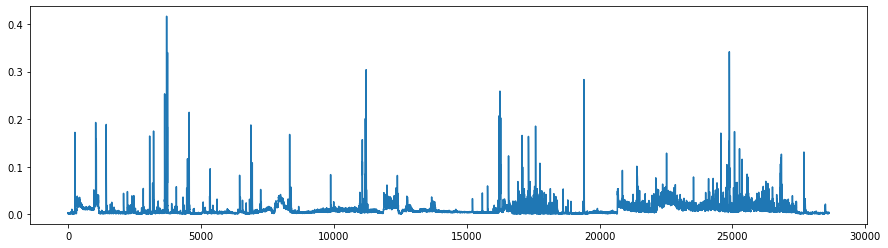

In [55]:
with VideoFileClip("./andrea_raw.MOV") as clip:
    get_clipped_video(clip, 30, 35) #edit these start and end times as necessary
    
    volumes = get_volume_array(clip)
    
    plt.figure(figsize=(15, 4))
    plt.plot(range(len(volumes)), volumes)
    plt.show()